# TECHNICAL REPORT: Multi-Trip VRP (2-Vehicle Fleet)

## 1. Scenario Definition

In this version, a realistic operation is modeled where the fleet is limited, but time is not. 

**Parameters:**
* **Capacity:** 80 kg (Standard).
* **Physical Fleet:** 2 Vehicles.
* **Operation:** Vehicles can return to the depot, reload, and perform a second trip.

**Solution Logic:**
The Genetic Algorithm will calculate the necessary trips (logical routes) to meet all demand. Subsequently, an assignment algorithm will distribute these trips among the 2 available vehicles to balance the workload.

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Data
depot = [20, 120]
customers = [
    [35, 115], [50, 140], [70, 100], [40, 80], [25, 60]
]
weights = [1.2, 3.8, 7.5, 0.9, 15.4, 12.1, 4.3, 19.7, 8.6, 2.5]
orders = [
    [(3, 2), (1, 3)],
    [(2, 6)],
    [(7, 4), (5, 2)],
    [(3, 8)],
    [(6, 5), (9, 2)]
]

capacity = 80
num_physical_vehicles = 2

In [2]:
# Demand Calculation
demands = []
for order in orders:
    total = 0
    for item, qty in order:
        total += weights[item - 1] * qty
    demands.append(total)

valid_customers = []
valid_demands = []
for i in range(len(customers)):
    if demands[i] <= capacity:
        valid_customers.append(customers[i])
        valid_demands.append(demands[i])

print(f"Total Demand to serve: {sum(valid_demands)} kg")

Total Demand to serve: 227.1 kg


In [3]:
# --- GA Logic (Identical to base version) ---
# The GA seeks to minimize the total distance of necessary trips.
# We will then assign those trips to the cars.

def distance(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def split_into_routes(route):
    routes = []
    load = 0
    current_route = []
    for c in route:
        if load + valid_demands[c] <= capacity:
            current_route.append(c)
            load += valid_demands[c]
        else:
            routes.append(current_route)
            current_route = [c]
            load = valid_demands[c]
    if current_route:
        routes.append(current_route)
    return routes

def total_distance(route):
    routes = split_into_routes(route)
    total = 0
    for r in routes:
        pos = depot
        for c in r:
            total += distance(pos, valid_customers[c])
            pos = valid_customers[c]
        total += distance(pos, depot)
    return total

def fitness(route):
    return total_distance(route)

def create_population(n, num_customers):
    population = []
    base = list(range(num_customers))
    for _ in range(n):
        r = base[:]
        random.shuffle(r)
        population.append(r)
    return population

def selection(population, fitness_values):
    i1, i2 = random.sample(range(len(population)), 2)
    return population[i1][:] if fitness_values[i1] < fitness_values[i2] else population[i2][:]

def crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    child = [-1] * len(p1)
    child[a:b] = p1[a:b]
    pos = b
    for x in p2:
        if x not in child:
            if pos >= len(p1): pos = 0
            child[pos] = x
            pos += 1
    return child

def mutation(route, prob=0.1):
    if random.random() < prob:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]

def genetic_algorithm(n_generations=200, pop_size=50):
    population = create_population(pop_size, len(valid_customers))
    fitness_values = [fitness(r) for r in population]

    for _ in range(n_generations):
        new_population = []
        for _ in range(pop_size):
            p1 = selection(population, fitness_values)
            p2 = selection(population, fitness_values)
            child = crossover(p1, p2)
            mutation(child, 0.1)
            new_population.append(child)
        population = new_population
        fitness_values = [fitness(r) for r in population]

    best_idx = min(range(pop_size), key=lambda i: fitness_values[i])
    return population[best_idx], fitness_values[best_idx]

In [4]:
# Execute GA to get necessary logical routes
best_route, best_value = genetic_algorithm()
necessary_trips = split_into_routes(best_route)

print(f"Total trips necessary: {len(necessary_trips)}")

# --- ASSIGNMENT OF TRIPS TO PHYSICAL VEHICLES ---
# Simple 'Round Robin' assignment to balance workload
assigned_vehicles = {0: [], 1: []} # Vehicle 0 and Vehicle 1

for i, trip in enumerate(necessary_trips):
    vehicle_id = i % num_physical_vehicles
    assigned_vehicles[vehicle_id].append(trip)

print("\n--- Fleet Planning ---")
for v_id, trips in assigned_vehicles.items():
    print(f"PHYSICAL VEHICLE {v_id + 1}:")
    if not trips:
        print("  (No activity)")
    for idx, r in enumerate(trips):
        load = sum(valid_demands[c] for c in r)
        print(f"  -> Shift {idx+1}: Customers {r} | Load: {round(load, 1)} kg")

Total trips necessary: 3

--- Fleet Planning ---
PHYSICAL VEHICLE 1:
  -> Shift 1: Customers [1, 2] | Load: 70.8 kg
  -> Shift 2: Customers [0, 3] | Load: 78.6 kg
PHYSICAL VEHICLE 2:
  -> Shift 1: Customers [4] | Load: 77.7 kg


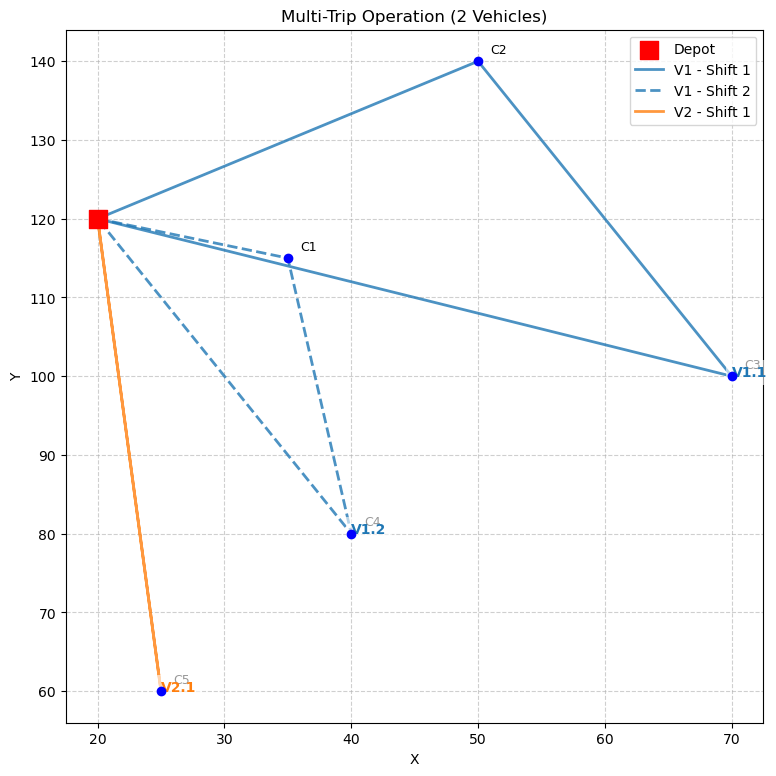

In [5]:
def plot_multitrip(assigned_vehicles):
    plt.figure(figsize=(9, 9))
    
    # Depot
    plt.scatter(depot[0], depot[1], c='red', s=150, marker='s', label='Depot', zorder=10)
    
    # Customers
    for i, (x, y) in enumerate(valid_customers):
        plt.scatter(x, y, c='blue', zorder=5)
        plt.text(x+1, y+1, f'C{i+1}', fontsize=9)

    vehicle_colors = ['#1f77b4', '#ff7f0e'] # Blue and Orange
    line_styles = ['-', '--', ':'] # Solid, Dashed, Dotted (to distinguish shifts)
    
    for v_id, trips in assigned_vehicles.items():
        color = vehicle_colors[v_id]
        
        for idx_trip, r in enumerate(trips):
            style = line_styles[idx_trip % len(line_styles)]
            
            points = [depot] + [valid_customers[c] for c in r] + [depot]
            xs = [p[0] for p in points]
            ys = [p[1] for p in points]
            
            label = f'V{v_id+1} - Shift {idx_trip+1}'
            plt.plot(xs, ys, linestyle=style, color=color, linewidth=2, label=label, alpha=0.8)
            
            # Annotate load in the center of the route
            mid = len(xs) // 2
            plt.text(xs[mid], ys[mid], f'V{v_id+1}.{idx_trip+1}', 
                     color=color, fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    plt.title("Multi-Trip Operation (2 Vehicles)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_multitrip(assigned_vehicles)

## 5. Final Conclusions (Multi-Trip Scenario)

By allowing vehicles to make multiple trips (reload at depot), full demand is met under the original constraints (80 kg Capacity and 2 Vehicles):

1.  **Double Shift Operation:**
    * Demand analysis (227.1 kg) determines that **3 trips** in total are necessary.
    * With 2 vehicles available, the optimal solution implies an asymmetry in workload:
        * **Vehicle 1:** Performs **2 Shifts**. (Ex: A heavy trip with Customer 5, return, and a second light trip).
        * **Vehicle 2:** Performs **1 Shift**.

2.  **Asset Efficiency:**
    * This strategy avoids investment in a third truck or larger trucks.
    * The cost to pay is not monetary (investment), but temporal: total operation time extends because a vehicle must wait to return to the depot to start its second route.

3.  **Flexibility:**
    * The model demonstrates robustness. Although the 80 kg capacity is limiting (highly fragments orders), the 'return and reload' policy allows 100% service completion without leaving customers unattended.